Dependencies

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr

In [39]:
df = pd.read_csv("final_with_FPKM_half_life.csv")

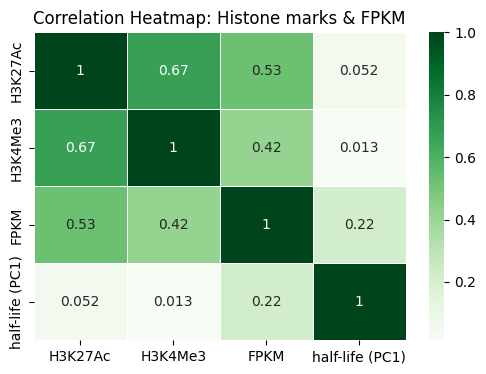

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load your merged file
df = pd.read_csv("final_with_FPKM_half_life.csv")

# Select numeric columns only
corr = df[["H3K27Ac", "H3K4Me3", "FPKM", "half-life (PC1)"]].corr(method='spearman')

# Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Greens", linewidths=0.5)
plt.title("Correlation Heatmap: Histone marks & FPKM")
plt.show()

LOG TRANSFORM FEATURES → BOOST REGRESSION POWER

In [41]:
df["logH3K27Ac"] = np.log1p(df["H3K27Ac"])
df["logH3K4Me3"] = np.log1p(df["H3K4Me3"])
df["logHL"]      = np.log1p(df["half-life (PC1)"].fillna(0))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Feature Selection

In [42]:
df["K27xK4"]  = df["logH3K27Ac"] * df["logH3K4Me3"]
df["K27xHL"]  = df["logH3K27Ac"] * df["logHL"]
df["K4xHL"]   = df["logH3K4Me3"] * df["logHL"]
features = ["logH3K27Ac","logH3K4Me3","logHL","K27xK4","K27xHL","K4xHL"]
X = df[features]

In [43]:
X

,logH3K27Ac,logH3K4Me3,logHL,K27xK4,K27xHL,K4xHL
0,2.302585,1.386294,2.188043,3.192061,5.038156,3.033272
1,1.945910,1.791759,0.719334,3.486603,1.399759,1.288873
2,2.397895,1.791759,-1.952957,4.296452,-4.682987,-3.499230
3,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.386294,1.386294,1.649286,1.921812,2.286396,2.286396
...,...,...,...,...,...,...
29593,2.079442,1.098612,1.498977,2.284500,3.117035,1.646795
29594,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
29595,1.791759,1.386294,2.102755,2.483906,3.767630,2.915037
29596,0.000000,0.000000,1.167360,0.000000,0.000000,0.000000


In [44]:
y_log = np.log1p(df["FPKM"])
y_fpkm = df["FPKM"]

In [45]:
y_log

,FPKM
0,3.395314
1,2.557658
2,0.061639
3,0.036302
4,1.602264
...,...
29593,1.129760
29594,0.000000
29595,1.811255
29596,0.652995


In [46]:
y_fpkm

,FPKM
0,28.824021
1,11.905556
2,0.063578
3,0.036968
4,3.964257
...,...
29593,2.094914
29594,0.000000
29595,5.118120
29596,0.921286


In [47]:
X_train, X_test, y_train_log, y_test_log, y_train_fpkm, y_test_fpkm = train_test_split(
    X, y_log, y_fpkm, test_size=0.10, random_state=42)

In [48]:
model = RandomForestRegressor(
    n_estimators=800,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42)

model.fit(X_train, y_train_log)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=4, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [49]:
y_pred_log = model.predict(X_test)
y_pred_fpkm = np.expm1(y_pred_log)

In [50]:
y_pred_log

array([0.56502418, 0.5495952 , 1.75471868, ..., 0.04392813, 0.04392813,
       0.39826612])

In [51]:
y_pred_fpkm

array([0.75949033, 0.73255154, 4.78182099, ..., 0.04490725, 0.04490725,
       0.4892403 ])

In [52]:
y_test_fpkm

,FPKM
4203,0.000000
24886,0.002310
25042,4.468147
4589,3.081838
4475,0.465438
...,...
3710,8.975923
29204,5.219395
7841,0.000000
29228,0.000000


In [53]:
y_pred_fpkm

array([0.75949033, 0.73255154, 4.78182099, ..., 0.04490725, 0.04490725,
       0.4892403 ])

In [54]:
residual_fpkm = y_test_fpkm - y_pred_fpkm

In [55]:
residual_fpkm

,FPKM
4203,-0.759490
24886,-0.730242
25042,-0.313674
4589,-2.332945
4475,-7.547458
...,...
3710,-2.263971
29204,1.848578
7841,-0.044907
29228,-0.044907


In [56]:
valid = X_test["logHL"].notna()
spearman_corr, pval = spearmanr(y_test_fpkm[valid], y_pred_fpkm[valid])

print("\n===== MODEL OUTPUT TABLE =====")
df_out = pd.DataFrame({
    "Actual_FPKM": y_test_fpkm.values,
    "Pred_FPKM": y_pred_fpkm,
    "Residual_FPKM": residual_fpkm
})
print(df_out.head(), "\n")

#========================================
# PERFORMANCE METRICS
#========================================
print("===== MODEL PERFORMANCE =====")
print(f"R² (log scale) = {r2_score(y_test_log,y_pred_log):.3f}")
print(f"Spearman corr (Pred vs Actual FPKM) = {spearman_corr:.3f}   p = {pval:.2e}")
print(f"MAE = {mean_absolute_error(y_test_fpkm,y_pred_fpkm):.3f}")
# Fix: Calculate RMSE by taking the square root of MSE
print(f"RMSE = {np.sqrt(mean_squared_error(y_test_fpkm,y_pred_fpkm)):.3f}")
print(f"Rows used for Spearman = {valid.sum()}")


===== MODEL OUTPUT TABLE =====
       Actual_FPKM  Pred_FPKM  Residual_FPKM
4203      0.000000   0.759490      -0.759490
24886     0.002310   0.732552      -0.730242
25042     4.468147   4.781821      -0.313674
4589      3.081838   5.414782      -2.332945
4475      0.465438   8.012895      -7.547458 

===== MODEL PERFORMANCE =====
R² (log scale) = 0.391
Spearman corr (Pred vs Actual FPKM) = 0.704   p = 4.51e-308
MAE = 8.633
RMSE = 37.915
Rows used for Spearman = 2059


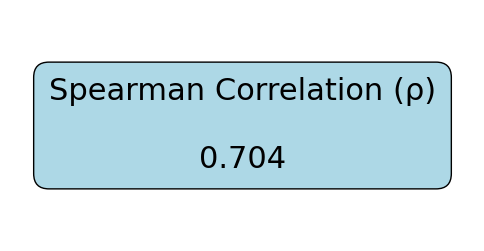

In [57]:
rho = 0.704

plt.figure(figsize=(6,3))
plt.text(0.5, 0.5, f"Spearman Correlation (ρ)\n\n{rho:.3f}",
         ha='center', va='center', fontsize=22,
         bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))

plt.axis('off')
plt.show()


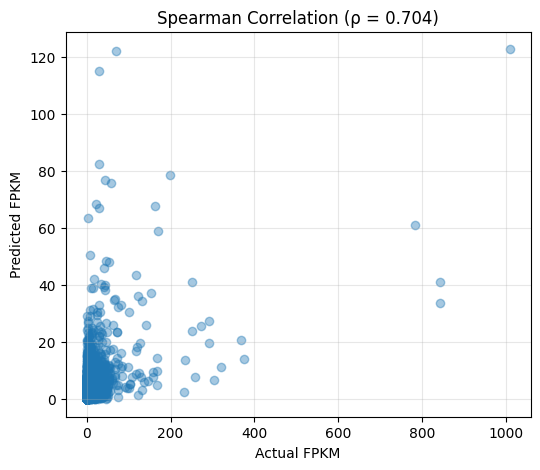

In [58]:
plt.figure(figsize=(6,5))
plt.scatter(y_test_fpkm, y_pred_fpkm, alpha=0.4)
plt.xlabel("Actual FPKM")
plt.ylabel("Predicted FPKM")
plt.title("Spearman Correlation (ρ = 0.704)")
plt.grid(alpha=0.3)
plt.show()


In [59]:
residual_log=np.log1p(residual_fpkm)
residual_log

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,FPKM
4203,-1.424995
24886,-1.310228
25042,-0.376402
4589,NaN
4475,NaN
...,...
3710,NaN
29204,1.046820
7841,-0.045947
29228,-0.045947


In [60]:
df["logHL"]

,logHL
0,2.188043
1,0.719334
2,-1.952957
3,0.000000
4,1.649286
...,...
29593,1.498977
29594,0.000000
29595,2.102755
29596,1.167360


In [61]:
# Combine into one dataframe
corr_df = pd.DataFrame({
    "res_log": residual_log,
    "logHL": df["logHL"]
})

# Drop NA values
corr_df = corr_df.dropna()

# Spearman correlation
spearman_corr = corr_df.corr(method="spearman")

spearman_corr


,res_log,logHL
res_log,1.000000,0.422911
logHL,0.422911,1.000000


In [62]:
spearman_corr.loc["res_log", "logHL"]

np.float64(0.42291076700065533)

In [63]:
residual_fpkm

,FPKM
4203,-0.759490
24886,-0.730242
25042,-0.313674
4589,-2.332945
4475,-7.547458
...,...
3710,-2.263971
29204,1.848578
7841,-0.044907
29228,-0.044907


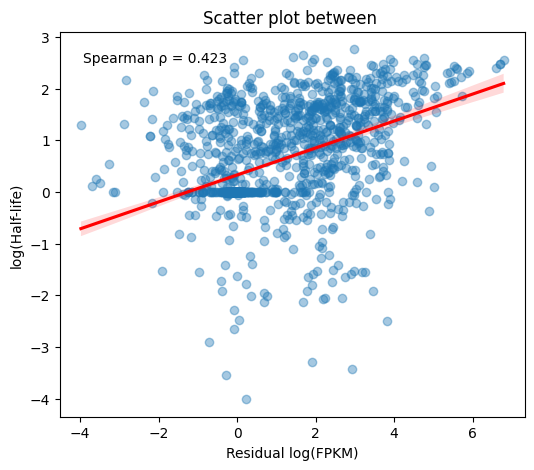

In [64]:
# Calculate Spearman correlation
rho = corr_df["res_log"].corr(corr_df["logHL"], method="spearman")

plt.figure(figsize=(6,5))

sns.regplot(
    x="res_log",
    y="logHL",
    data=corr_df,
    scatter_kws={'alpha':0.4},
    line_kws={'color':'red'}
)

plt.xlabel("Residual log(FPKM)")
plt.ylabel("log(Half-life)")
plt.title("Scatter plot between ")

# Add Spearman correlation text
plt.text(
    0.05, 0.95,                    # position in axis fraction
    f"Spearman ρ = {rho:.3f}",     # text content
    transform=plt.gca().transAxes, # use axes coordinates
    fontsize=10,
    verticalalignment='top'
)

plt.show()